In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class SimpleUNet(nn.Module):
    def __init__(self, in_channels=3, n_classes=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)

        for feature in features:
            self.encoder.append(ConvBlock(in_channels, feature))
            in_channels = feature

        self.bottleneck = ConvBlock(features[-1], features[-1] * 2)

        self.upconvs = nn.ModuleList()
        self.decoder = nn.ModuleList()

        for feature in reversed(features):
            self.upconvs.append(nn.ConvTranspose2d(feature * 2, feature, 2, 2))
            self.decoder.append(ConvBlock(feature * 2, feature))

        self.final_conv = nn.Conv2d(features[0], n_classes, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.encoder:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(len(self.upconvs)):
            x = self.upconvs[idx](x)
            skip_connection = skip_connections[idx]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=False)

            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx](x)

        return self.final_conv(x)  # No softmax here



# Example usage
if __name__ == "__main__":
    # Create simplified model
    model = SimpleUNet(n_classes=5)
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Test with sample input
    x = torch.randn(2, 3, 256, 256)  # batch_size=2, channels=3, height=256, width=256
    
    model.eval()
    with torch.no_grad():
        output = model(x)
        predictions = torch.argmax(output, dim=1)
    
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Predictions shape: {predictions.shape}")
    
    # Training example
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    
    # Dummy training step
    target = torch.randint(0, 4, (2, 256, 256))
    
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    
    print(f"Training loss: {loss.item():.4f}")


Model parameters: 31,043,781
Input shape: torch.Size([2, 3, 256, 256])
Output shape: torch.Size([2, 5, 256, 256])
Predictions shape: torch.Size([2, 256, 256])
Training loss: 1.6631


Dataset: 90 samples | Train: 62 | Val: 18 | Test: 10

=== DETAILED MASK INSPECTION ===
Sample 0:
  Shape: (256, 256)
  Dtype: int64
  Classes: [0 1 2 3 4]
  Class counts: [ 6971  1069  4756  1667 51073]
  Min/Max: 0/4
  Class 0: 6971 pixels (10.6%)
  Class 1: 1069 pixels (1.6%)
  Class 2: 4756 pixels (7.3%)
  Class 3: 1667 pixels (2.5%)
  Class 4: 51073 pixels (77.9%)

Sample 1:
  Shape: (256, 256)
  Dtype: int64
  Classes: [0 1 2 3 4]
  Class counts: [ 5884  1076  4910  1661 52005]
  Min/Max: 0/4
  Class 0: 5884 pixels (9.0%)
  Class 1: 1076 pixels (1.6%)
  Class 2: 4910 pixels (7.5%)
  Class 3: 1661 pixels (2.5%)
  Class 4: 52005 pixels (79.4%)

Sample 2:
  Shape: (256, 256)
  Dtype: int64
  Classes: [0 1 2 3 4]
  Class counts: [ 3347  1068  5098  1621 54402]
  Min/Max: 0/4
  Class 0: 3347 pixels (5.1%)
  Class 1: 1068 pixels (1.6%)
  Class 2: 5098 pixels (7.8%)
  Class 3: 1621 pixels (2.5%)
  Class 4: 54402 pixels (83.0%)

Training Config:
  Device: cuda
  Model parameters: 31,043,7

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


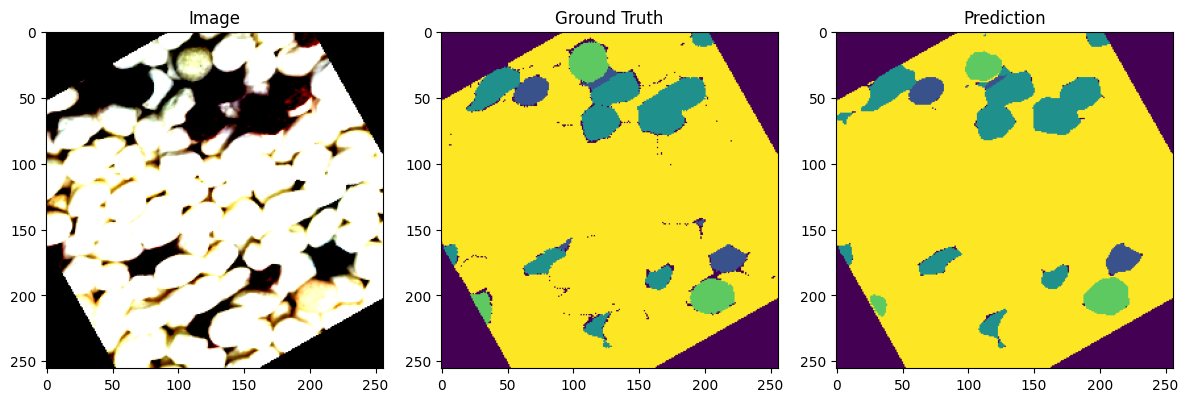

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from PIL import Image
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from collections import defaultdict
import time
import random

# --- Joint transform class with debug ---
class JointTransform:
    def __init__(self, img_size=256):
        self.img_size = img_size

    def __call__(self, image, mask):
        # Resize
        image = image.resize((self.img_size, self.img_size), Image.BILINEAR)
        mask = mask.resize((self.img_size, self.img_size), Image.NEAREST)

        # Random horizontal flip
        if random.random() > 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)

        # Random vertical flip
        if random.random() > 0.5:
            image = image.transpose(Image.FLIP_TOP_BOTTOM)
            mask = mask.transpose(Image.FLIP_TOP_BOTTOM)

        # Random rotation
        angle = random.uniform(-30, 30)
        image = image.rotate(angle, resample=Image.BILINEAR, fillcolor=(0, 0, 0))
        mask = mask.rotate(angle, resample=Image.NEAREST, fillcolor=0)

        # Convert to tensor and normalize image
        image = transforms.ToTensor()(image)
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])(image)

        # Convert mask to tensor long
        mask = torch.from_numpy(np.array(mask)).long()

        return image, mask


# --- Dataset with joint transform ---
class BeadDataset(Dataset):
    def __init__(self, image_dir, mask_dir, joint_transform=None, debug=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.joint_transform = joint_transform
        self.debug = debug
        self.images = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

        if self.debug:
            print(f"[BeadDataset] Found {len(self.images)} images in {image_dir}")
            print(f"[BeadDataset] First few images: {self.images[:3]}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        mask_path = os.path.join(self.mask_dir, img_name)
        if not os.path.exists(mask_path):
            base_name = os.path.splitext(img_name)[0]
            for ext in ['.png', '.jpg', '.jpeg']:
                mask_path = os.path.join(self.mask_dir, base_name + ext)
                if os.path.exists(mask_path):
                    break
            else:
                raise FileNotFoundError(f"No mask found for image {img_name} in {self.mask_dir}")

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)

        if self.debug and idx < 3:
            print(f"\n[BeadDataset DEBUG] Sample {idx}:")
            print(f"Image path: {img_path}")
            print(f"Mask path: {mask_path}")
            print(f"Mask mode: {mask.mode}")
            mask_arr = np.array(mask)
            print(f"Mask shape: {mask_arr.shape}, dtype: {mask_arr.dtype}")
            print(f"Mask unique values: {np.unique(mask_arr)}")

        # Convert mask multi-channel to single if needed
        mask_array = np.array(mask)
        if len(mask_array.shape) > 2:
            mask_array = mask_array[:, :, 0]
            mask = Image.fromarray(mask_array.astype(np.uint8), mode='L')

        if self.joint_transform:
            image, mask = self.joint_transform(image, mask)
        else:
            # No augmentation fallback
            image = transforms.ToTensor()(image)
            image = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])(image)
            mask = torch.from_numpy(np.array(mask)).long()

        if self.debug and idx < 3:
            print(f"[BeadDataset DEBUG] After transform:")
            print(f"Image tensor shape: {image.shape}, dtype: {image.dtype}")
            print(f"Mask tensor shape: {mask.shape}, dtype: {mask.dtype}")
            unique_mask = torch.unique(mask)
            print(f"Mask unique values: {unique_mask}")

        return image, mask


class DiceScore(nn.Module):
    """Dice coefficient for segmentation evaluation with debugging"""
    
    def __init__(self, num_classes, smooth=1e-6, debug=False):
        super().__init__()
        self.num_classes = num_classes
        self.smooth = smooth
        self.debug = debug
        self.call_count = 0
    
    def forward(self, pred, target):
        pred = F.softmax(pred, dim=1)
        dice_scores = []
        
        # Debug first few calls
        if self.debug and self.call_count < 5:
            print(f"\n=== DICE DEBUG CALL {self.call_count} ===")
            print(f"Pred shape: {pred.shape}")
            print(f"Target shape: {target.shape}")
            print(f"Target unique values: {torch.unique(target)}")
            print(f"Target value counts: {torch.bincount(target.flatten())}")
            
            # Check prediction distribution
            pred_classes = torch.argmax(pred, dim=1)
            print(f"Predicted classes unique: {torch.unique(pred_classes)}")
            print(f"Predicted classes counts: {torch.bincount(pred_classes.flatten())}")
        
        for i in range(self.num_classes):
            pred_i = pred[:, i]
            target_i = (target == i).float()
            
            intersection = (pred_i * target_i).sum()
            union = pred_i.sum() + target_i.sum()
            
            dice = (2 * intersection + self.smooth) / (union + self.smooth)
            dice_scores.append(dice)
            
            # Debug class-specific dice
            if self.debug and self.call_count < 5:
                print(f"Class {i}: intersection={intersection:.4f}, union={union:.4f}, dice={dice:.4f}")
        
        if self.debug and self.call_count < 5:
            print("=" * 30)
        
        self.call_count += 1
        return torch.stack(dice_scores).mean()


class SqueezeToLong:
    """Custom transform to replace lambda for multiprocessing compatibility"""
    def __call__(self, x):
        return x.squeeze().long()


class SegmentationTrainer:
    """Complete training pipeline for SimpleUNet with enhanced debugging"""
    
    def __init__(self, model, device, train_loader, val_loader, n_classes=4, debug=False):
        self.model = model.to(device)
        self.device = device
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.n_classes = n_classes
        self.debug = debug
        
        # Ensure model uses GPU efficiently
        if torch.cuda.is_available():
            self.model = self.model.cuda()
            if torch.cuda.device_count() > 1:
                self.model = nn.DataParallel(self.model)
        
        # Loss functions
        self.criterion = nn.CrossEntropyLoss()
        self.dice_metric = DiceScore(n_classes, debug=debug)
        
        # Optimizer and scheduler
        self.optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=1e-3, 
            weight_decay=1e-4
        )
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, 
            mode='min', 
            factor=0.5, 
            patience=5
        )
        
        # Training history
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_dice': [],
            'val_dice': [],
            'lr': []
        }
        
        # Best model tracking
        self.best_dice = 0.0
        self.best_model_state = None
        
        # Track scheduler events
        self.previous_lr = self.optimizer.param_groups[0]['lr']
    
    def debug_batch(self, data, target, output, batch_idx, phase="train"):
        """Debug a single batch"""
        if batch_idx == 0:  # Debug first batch only
            print(f"\n=== {phase.upper()} BATCH DEBUG ===")
            print(f"Input shape: {data.shape}")
            print(f"Target shape: {target.shape}")
            print(f"Output shape: {output.shape}")
            print(f"Target unique values: {torch.unique(target)}")
            print(f"Target value distribution: {torch.bincount(target.flatten())}")
            
            # Check model output
            pred_classes = torch.argmax(output, dim=1)
            print(f"Predicted classes unique: {torch.unique(pred_classes)}")
            print(f"Predicted classes distribution: {torch.bincount(pred_classes.flatten())}")
            
            # Check if model is predicting only one class
            pred_probs = F.softmax(output, dim=1)
            for i in range(self.n_classes):
                class_prob = pred_probs[:, i].mean()
                print(f"Class {i} avg probability: {class_prob:.4f}")
            
            print("=" * 40)
    
    def train_epoch(self):
        """Train for one epoch with debugging"""
        self.model.train() 
        running_loss = 0.0
        running_dice = 0.0
        
        for batch_idx, (data, target) in enumerate(self.train_loader):
            data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
            
            # Forward pass
            self.optimizer.zero_grad()
            output = self.model(data)
            
            # Debug first batch
            if self.debug and batch_idx == 0:
                self.debug_batch(data, target, output, batch_idx, "train")
            
            # Calculate loss
            loss = self.criterion(output, target)
            dice = self.dice_metric(output, target)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            # Update metrics
            running_loss += loss.item()
            running_dice += dice.item()
        
        avg_loss = running_loss / len(self.train_loader)
        avg_dice = running_dice / len(self.train_loader)
        
        return avg_loss, avg_dice
    
    def validate(self):
        """Validate the model with debugging"""
        self.model.eval()
        running_loss = 0.0
        running_dice = 0.0
        
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(self.val_loader):
                data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                
                output = self.model(data)
                
                # Debug first batch
                if self.debug and batch_idx == 0:
                    self.debug_batch(data, target, output, batch_idx, "val")
                
                loss = self.criterion(output, target)
                dice = self.dice_metric(output, target)
                
                running_loss += loss.item()
                running_dice += dice.item()
        
        avg_loss = running_loss / len(self.val_loader)
        avg_dice = running_dice / len(self.val_loader)
        
        return avg_loss, avg_dice
    
    def train(self, num_epochs, save_dir='checkpoints', print_every=1):
        """Full training loop with debugging for first 5 epochs only"""
        os.makedirs(save_dir, exist_ok=True)
        
        print(f"Training Config:")
        print(f"  Device: {self.device}")
        print(f"  Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")
        print(f"  Epochs: {num_epochs}")
        print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB" if torch.cuda.is_available() else "")
        print(f"  Classes: {self.n_classes}")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            epoch_start = time.time()
            
            # Enable debug only for first 5 epochs
            self.debug = (epoch < 5)
            self.dice_metric.debug = (epoch < 5)
            
            # Training phase
            train_loss, train_dice = self.train_epoch()
            
            # Validation phase
            val_loss, val_dice = self.validate()
            
            # Update learning rate
            self.scheduler.step(val_loss)
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Check for LR reduction
            lr_reduced = current_lr != self.previous_lr
            if lr_reduced:
                self.previous_lr = current_lr
            
            # Save metrics
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_dice'].append(train_dice)
            self.history['val_dice'].append(val_dice)
            self.history['lr'].append(current_lr)
            
            # Save best model
            is_best = val_dice > self.best_dice
            if is_best:
                self.best_dice = val_dice
                self.best_model_state = self.model.state_dict().copy()
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'best_dice': self.best_dice,
                    'history': self.history
                }, os.path.join(save_dir, 'best_model.pth'))
            
            # Regular checkpoint every 100 epochs
            if (epoch + 1) % 100 == 0:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'history': self.history
                }, os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth'))
            
            # Print summary every epoch (or you can keep print_every logic if preferred)
            epoch_time = time.time() - epoch_start
            status = ""
            if is_best:
                status += " [BEST]"
            if lr_reduced:
                status += f" [LR: {current_lr:.6f}]"
            
            print(f"Epoch {epoch+1:4d}/{num_epochs} | "
                f"Train L: {train_loss:.4f} D: {train_dice:.4f} | "
                f"Val L: {val_loss:.4f} D: {val_dice:.4f} | "
                f"Time: {epoch_time:.1f}s{status}")
        
        total_time = time.time() - start_time
        print("-" * 60)
        print(f"Training completed in {total_time/60:.1f} minutes")
        print(f"Best validation Dice: {self.best_dice:.4f}")
        
        # Load best model
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
            print("Best model loaded.")

    
    def plot_training_history(self):
        """Plot training curves"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss curves
        axes[0, 0].plot(self.history['train_loss'], label='Train Loss')
        axes[0, 0].plot(self.history['val_loss'], label='Val Loss')
        axes[0, 0].set_title('Loss Curves')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Dice curves
        axes[0, 1].plot(self.history['train_dice'], label='Train Dice')
        axes[0, 1].plot(self.history['val_dice'], label='Val Dice')
        axes[0, 1].set_title('Dice Score Curves')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Dice Score')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Learning rate
        axes[1, 0].plot(self.history['lr'])
        axes[1, 0].set_title('Learning Rate')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True)
        
        # Combined metrics
        axes[1, 1].plot(self.history['val_loss'], label='Val Loss', alpha=0.7)
        ax2 = axes[1, 1].twinx()
        ax2.plot(self.history['val_dice'], label='Val Dice', color='orange', alpha=0.7)
        axes[1, 1].set_title('Validation Metrics')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss', color='blue')
        ax2.set_ylabel('Dice Score', color='orange')
        axes[1, 1].grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def evaluate_model(self, test_loader):
        """Comprehensive model evaluation"""
        self.model.eval()
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            for data, target in tqdm(test_loader, desc='Evaluating'):
                data, target = data.to(self.device, non_blocking=True), target.to(self.device, non_blocking=True)
                
                output = self.model(data)
                pred = torch.argmax(output, dim=1)
                
                all_predictions.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
        
        # Classification report
        print("\nClassification Report:")
        print(classification_report(all_targets, all_predictions))
        
        # Confusion matrix
        cm = confusion_matrix(all_targets, all_predictions)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        return all_predictions, all_targets


class MaskToTensor:
    """Enhanced mask to tensor conversion with debugging"""
    def __init__(self, debug=False):
        self.debug = debug
        self.call_count = 0
    
    def __call__(self, pic):
        if self.debug and self.call_count < 3:
            print(f"\n=== MaskToTensor DEBUG {self.call_count} ===")
            pic_array = np.array(pic)
            print(f"Input type: {type(pic)}")
            print(f"Input shape: {pic_array.shape}")
            print(f"Input dtype: {pic_array.dtype}")
            print(f"Input min/max: {pic_array.min()}/{pic_array.max()}")
            print(f"Input unique: {np.unique(pic_array)}")
            
            result = torch.from_numpy(pic_array).long()
            print(f"Output shape: {result.shape}")
            print(f"Output dtype: {result.dtype}")
            print(f"Output min/max: {result.min()}/{result.max()}")
            print(f"Output unique: {torch.unique(result)}")
            print("=" * 30)
            
        self.call_count += 1
        return torch.from_numpy(np.array(pic)).long()


# --- Updated create_data_loaders with debug ---
def create_data_loaders(data_dir, batch_size=8, img_size=256,
                        train_ratio=0.7, val_ratio=0.2, test_ratio=0.1,
                        random_seed=42, debug=False):

    if abs(train_ratio + val_ratio + test_ratio - 1.0) > 1e-6:
        raise ValueError("train_ratio + val_ratio + test_ratio must equal 1.0")

    random.seed(random_seed)

    train_joint_transform = JointTransform(img_size=img_size)

    # For val/test: simple resize + tensor + normalize (no augmentation)
    def val_test_transform(img, msk):
        img = img.resize((img_size, img_size), Image.BILINEAR)
        msk = msk.resize((img_size, img_size), Image.NEAREST)
        img = transforms.ToTensor()(img)
        img = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])(img)
        msk = torch.from_numpy(np.array(msk)).long()
        return img, msk

    full_dataset = BeadDataset(
        os.path.join(data_dir, 'images'),
        os.path.join(data_dir, 'masks'),
        joint_transform=None,
        debug=debug
    )

    total_samples = len(full_dataset)

    indices = list(range(total_samples))
    train_size = int(train_ratio * total_samples)
    val_size = int(val_ratio * total_samples)
    test_size = total_samples - train_size - val_size

    train_indices, temp_indices = train_test_split(indices, train_size=train_size,
                                                  random_state=random_seed, shuffle=True)
    val_indices, test_indices = train_test_split(temp_indices, train_size=val_size,
                                                random_state=random_seed, shuffle=True)

    train_dataset = BeadDataset(
        os.path.join(data_dir, 'images'),
        os.path.join(data_dir, 'masks'),
        joint_transform=train_joint_transform,
        debug=debug
    )

    val_dataset = BeadDataset(
        os.path.join(data_dir, 'images'),
        os.path.join(data_dir, 'masks'),
        joint_transform=val_test_transform,
        debug=False
    )

    test_dataset = BeadDataset(
        os.path.join(data_dir, 'images'),
        os.path.join(data_dir, 'masks'),
        joint_transform=val_test_transform,
        debug=False
    )

    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(val_dataset, val_indices)
    test_subset = Subset(test_dataset, test_indices)

    num_workers = 0
    pin_memory = torch.cuda.is_available()

    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    test_loader = DataLoader(
        test_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    print(f"Dataset: {total_samples} samples | Train: {len(train_indices)} | Val: {len(val_indices)} | Test: {len(test_indices)}")

    return train_loader, val_loader, test_loader

def print_first_mask_classes(dataset):
    """Enhanced mask class inspection"""
    print("\n=== DETAILED MASK INSPECTION ===")
    
    # Check first 3 samples
    for i in range(min(3, len(dataset))):
        _, mask = dataset[i]
        
        if isinstance(mask, torch.Tensor):
            mask_np = mask.numpy()
        else:
            mask_np = np.array(mask)
            
        unique_classes = np.unique(mask_np)
        class_counts = np.bincount(mask_np.flatten())
        
        print(f"Sample {i}:")
        print(f"  Shape: {mask_np.shape}")
        print(f"  Dtype: {mask_np.dtype}")
        print(f"  Classes: {unique_classes}")
        print(f"  Class counts: {class_counts}")
        print(f"  Min/Max: {mask_np.min()}/{mask_np.max()}")
        
        # Check class distribution
        total_pixels = mask_np.size
        for class_id in unique_classes:
            count = class_counts[class_id] if class_id < len(class_counts) else 0
            percentage = (count / total_pixels) * 100
            print(f"  Class {class_id}: {count} pixels ({percentage:.1f}%)")
        print()
    
    print("=" * 40)


def main():
    """Main training script with comprehensive debugging"""
    # Set device and optimize for GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # GPU optimizations
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False
    
    # Create model (you'll need to define SimpleUNet or import it)
    model = SimpleUNet(n_classes=5)
    
    # Create data loaders with debugging enabled
    train_loader, val_loader, test_loader = create_data_loaders(
        data_dir='UNET_dataset',
        batch_size=16,
        img_size=256,
        debug=False  # Enable debugging
    )
    
    # Enhanced mask inspection
    dataset_for_inspection = train_loader.dataset.dataset
    print_first_mask_classes(dataset_for_inspection)
    
    # Uncomment when you have the model defined
    trainer = SegmentationTrainer(
        model=model,
        device=device,
        train_loader=train_loader,
        val_loader=val_loader,
        n_classes=5,
        debug=False  # Enable debugging
    )
    
    trainer.train(num_epochs=100, print_every=1)  # Short debug run
    visualize_prediction(model, train_loader.dataset.dataset, device)

def visualize_prediction(model, dataset, device):
    model.eval()
    image, mask = dataset[0]
    image = image.to(device).unsqueeze(0)

    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(image.squeeze().permute(1, 2, 0).cpu())
    ax[0].set_title('Image')
    ax[1].imshow(mask)
    ax[1].set_title('Ground Truth')
    ax[2].imshow(pred)
    ax[2].set_title('Prediction')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

Loading checkpoint from: checkpoints/best_model.pth
Loaded model with best Dice score: 0.7404
Checkpoint loaded successfully!


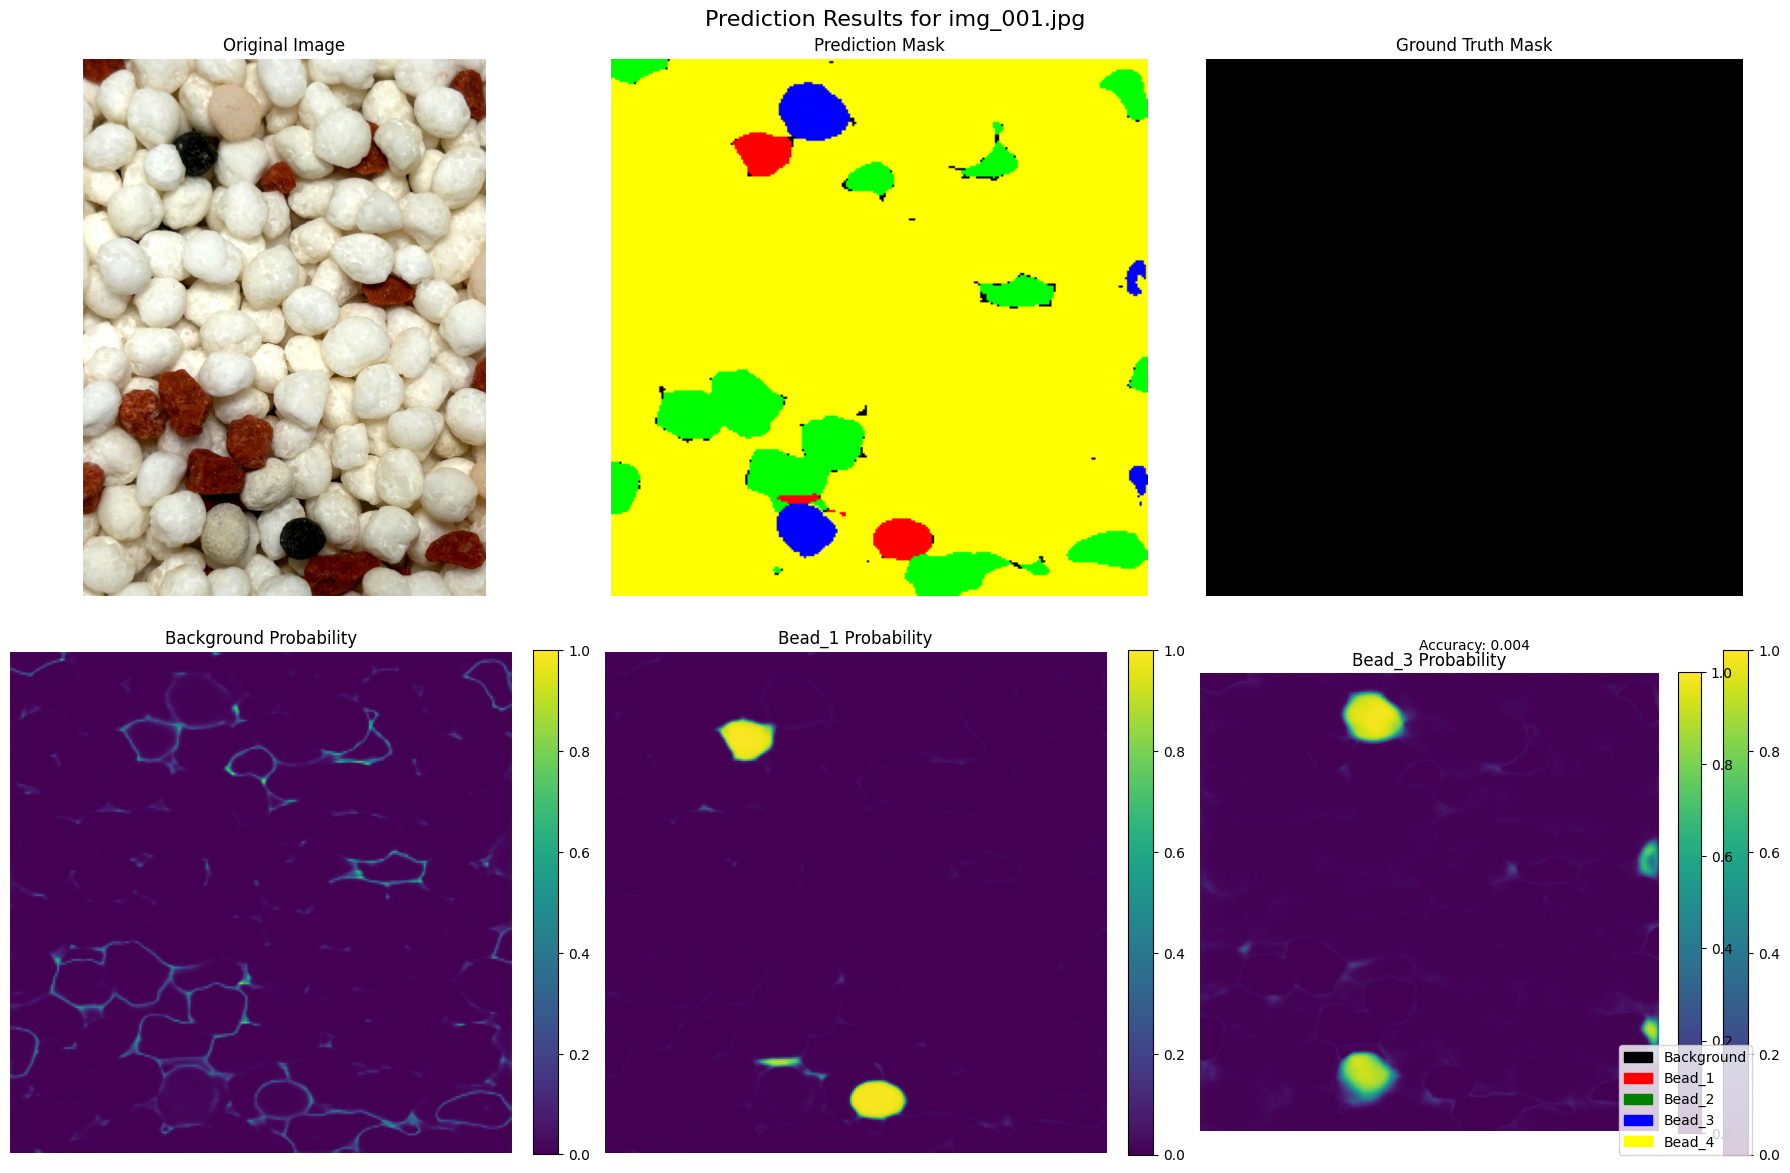

In [4]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random
from typing import List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

class ModelTester:
    """Test and visualize model predictions"""
    
    def __init__(self, model, device, checkpoint_path=None):
        self.model = model
        self.device = device
        
        # Load checkpoint if provided
        if checkpoint_path and os.path.exists(checkpoint_path):
            self.load_checkpoint(checkpoint_path)
        
        self.model.to(device)
        self.model.eval()
        
        # Define class names and colors for visualization
        self.class_names = ['Background', 'Bead_1', 'Bead_2', 'Bead_3', 'Bead_4']
        self.colors = ['black', 'red', 'green', 'blue', 'yellow']
        self.color_map = {i: self.colors[i] for i in range(len(self.class_names))}
    
    def load_checkpoint(self, checkpoint_path):
        """Load model from checkpoint"""
        print(f"Loading checkpoint from: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        
        # Handle different checkpoint formats
        if 'model_state_dict' in checkpoint:
            self.model.load_state_dict(checkpoint['model_state_dict'])
            if 'best_dice' in checkpoint:
                print(f"Loaded model with best Dice score: {checkpoint['best_dice']:.4f}")
        else:
            self.model.load_state_dict(checkpoint)
        
        print("Checkpoint loaded successfully!")
    
    def predict_single_image(self, image_path, mask_path=None):
        """Make prediction on a single image"""
        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        original_size = image.size
        
        # Transform for prediction
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        input_tensor = transform(image).unsqueeze(0).to(self.device)
        
        # Make prediction
        with torch.no_grad():
            output = self.model(input_tensor)
            probabilities = F.softmax(output, dim=1)
            prediction = torch.argmax(probabilities, dim=1)
        
        # Convert back to numpy
        prediction = prediction.cpu().numpy().squeeze()
        probabilities = probabilities.cpu().numpy().squeeze()
        
        # Load ground truth mask if provided
        ground_truth = None
        if mask_path and os.path.exists(mask_path):
            mask = Image.open(mask_path).convert('L')
            mask_transform = transforms.Compose([
                transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
                transforms.ToTensor()
            ])
            ground_truth = mask_transform(mask).squeeze().numpy().astype(np.uint8)
        
        return {
            'original_image': image,
            'prediction': prediction,
            'probabilities': probabilities,
            'ground_truth': ground_truth,
            'original_size': original_size
        }
    
    def visualize_prediction(self, image_path, mask_path=None, save_path=None):
        """Visualize prediction with detailed plots"""
        result = self.predict_single_image(image_path, mask_path)
        
        # Create subplots
        if result['ground_truth'] is not None:
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            fig.suptitle(f'Prediction Results for {os.path.basename(image_path)}', fontsize=16)
        else:
            fig, axes = plt.subplots(2, 2, figsize=(12, 12))
            fig.suptitle(f'Prediction Results for {os.path.basename(image_path)}', fontsize=16)
        
        # Original image
        axes[0, 0].imshow(result['original_image'])
        axes[0, 0].set_title('Original Image')
        axes[0, 0].axis('off')
        
        # Prediction mask
        prediction_colored = self.colorize_mask(result['prediction'])
        axes[0, 1].imshow(prediction_colored)
        axes[0, 1].set_title('Prediction Mask')
        axes[0, 1].axis('off')
        
        # Ground truth (if available)
        if result['ground_truth'] is not None:
            ground_truth_colored = self.colorize_mask(result['ground_truth'])
            axes[0, 2].imshow(ground_truth_colored)
            axes[0, 2].set_title('Ground Truth Mask')
            axes[0, 2].axis('off')
            
            # Calculate and display metrics
            accuracy = np.mean(result['prediction'] == result['ground_truth'])
            axes[0, 2].text(0.5, -0.1, f'Accuracy: {accuracy:.3f}', 
                           transform=axes[0, 2].transAxes, ha='center', fontsize=10)
        
        # Probability maps for each class
        for i in range(min(4, len(result['probabilities']))):
            if result['ground_truth'] is not None:
                row, col = 1, i if i < 3 else 0
                if i == 3:
                    col = 2
                if i >= 3:
                    row = 1
                axis = axes[row, col] if i < 3 else axes[1, 2]
            else:
                row, col = 1, i % 2
                if i >= 2:
                    break
                axis = axes[row, col]
            
            im = axis.imshow(result['probabilities'][i], cmap='viridis', vmin=0, vmax=1)
            axis.set_title(f'{self.class_names[i]} Probability')
            axis.axis('off')
            
            # Add colorbar
            plt.colorbar(im, ax=axis, fraction=0.046, pad=0.04)
        
        # Add legend for classes
        legend_elements = [plt.Rectangle((0,0),1,1, color=self.colors[i], label=self.class_names[i]) 
                          for i in range(len(self.class_names))]
        fig.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(0.98, 0.02))
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Visualization saved to: {save_path}")
        
        plt.show()
        
        return result
    
    def colorize_mask(self, mask):
        """Convert mask to colored visualization"""
        colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        
        for class_id in range(len(self.class_names)):
            class_mask = (mask == class_id)
            if class_id == 0:  # Background
                colored_mask[class_mask] = [0, 0, 0]
            elif class_id == 1:  # Bead_1
                colored_mask[class_mask] = [255, 0, 0]
            elif class_id == 2:  # Bead_2
                colored_mask[class_mask] = [0, 255, 0]
            elif class_id == 3:  # Bead_3
                colored_mask[class_mask] = [0, 0, 255]
            elif class_id == 4:  # Bead_4
                colored_mask[class_mask] = [255, 255, 0]  # yellow
        
        return colored_mask
    
    def test_random_samples(self, test_loader, num_samples=5):
        """Test on random samples from test loader"""
        # Get random samples
        random_indices = random.sample(range(len(test_loader.dataset)), num_samples)
        
        for i, idx in enumerate(random_indices):
            # Get sample from dataset
            if hasattr(test_loader.dataset, 'dataset'):  # If it's a Subset
                sample = test_loader.dataset.dataset[test_loader.dataset.indices[idx]]
            else:
                sample = test_loader.dataset[idx]
            
            image, mask = sample
            
            # Convert to PIL for visualization
            # Denormalize image
            mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
            denorm_image = image * std + mean
            denorm_image = torch.clamp(denorm_image, 0, 1)
            
            # Convert to numpy
            image_np = denorm_image.permute(1, 2, 0).numpy()
            mask_np = mask.numpy()
            
            # Make prediction
            with torch.no_grad():
                input_tensor = image.unsqueeze(0).to(self.device)
                output = self.model(input_tensor)
                probabilities = F.softmax(output, dim=1)
                prediction = torch.argmax(probabilities, dim=1)
            
            prediction = prediction.cpu().numpy().squeeze()
            probabilities = probabilities.cpu().numpy().squeeze()
            
            # Create visualization
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))
            fig.suptitle(f'Random Test Sample {i+1}', fontsize=16)
            
            # Original image
            axes[0, 0].imshow(image_np)
            axes[0, 0].set_title('Original Image')
            axes[0, 0].axis('off')
            
            # Ground truth
            gt_colored = self.colorize_mask(mask_np)
            axes[0, 1].imshow(gt_colored)
            axes[0, 1].set_title('Ground Truth')
            axes[0, 1].axis('off')
            
            # Prediction
            pred_colored = self.colorize_mask(prediction)
            axes[0, 2].imshow(pred_colored)
            axes[0, 2].set_title('Prediction')
            axes[0, 2].axis('off')
            
            # Calculate accuracy
            accuracy = np.mean(prediction == mask_np)
            axes[0, 2].text(0.5, -0.1, f'Accuracy: {accuracy:.3f}', 
                           transform=axes[0, 2].transAxes, ha='center')
            
            # Probability maps
            for class_id in range(min(3, len(probabilities))):
                im = axes[1, class_id].imshow(probabilities[class_id], cmap='viridis', vmin=0, vmax=1)
                axes[1, class_id].set_title(f'{self.class_names[class_id]} Probability')
                axes[1, class_id].axis('off')
                plt.colorbar(im, ax=axes[1, class_id], fraction=0.046, pad=0.04)
            
            plt.tight_layout()
            plt.show()
    
    def evaluate_on_test_set(self, test_loader):
        """Comprehensive evaluation on test set"""
        self.model.eval()
        all_predictions = []
        all_targets = []
        all_probabilities = []
        
        print("Evaluating on test set...")
        
        with torch.no_grad():
            for batch_idx, (images, masks) in enumerate(test_loader):
                images = images.to(self.device)
                masks = masks.to(self.device)
                
                # Make predictions
                outputs = self.model(images)
                probabilities = F.softmax(outputs, dim=1)
                predictions = torch.argmax(probabilities, dim=1)
                
                # Store results
                all_predictions.extend(predictions.cpu().numpy().flatten())
                all_targets.extend(masks.cpu().numpy().flatten())
                all_probabilities.extend(probabilities.cpu().numpy())
                
                if batch_idx % 10 == 0:
                    print(f'Batch {batch_idx}/{len(test_loader)}')
        
        # Calculate metrics
        accuracy = np.mean(np.array(all_predictions) == np.array(all_targets))
        
        # Create confusion matrix
        cm = confusion_matrix(all_targets, all_predictions)
        
        # Plot results
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=self.class_names, yticklabels=self.class_names,
                   ax=axes[0])
        axes[0].set_title('Confusion Matrix')
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('Actual')
        
        # Class-wise accuracy
        class_accuracies = cm.diagonal() / cm.sum(axis=1)
        axes[1].bar(self.class_names, class_accuracies, color=self.colors)
        axes[1].set_title('Class-wise Accuracy')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_ylim(0, 1)
        
        # Add accuracy values on bars
        for i, v in enumerate(class_accuracies):
            axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed report
        print(f"\nOverall Accuracy: {accuracy:.4f}")
        print(f"Mean Class Accuracy: {np.mean(class_accuracies):.4f}")
        print("\nClassification Report:")
        print(classification_report(all_targets, all_predictions, target_names=self.class_names))
        
        return {
            'accuracy': accuracy,
            'class_accuracies': class_accuracies,
            'confusion_matrix': cm,
            'predictions': all_predictions,
            'targets': all_targets
        }
    
    def compare_predictions(self, image_paths, mask_paths=None):
        """Compare predictions on multiple images"""
        if mask_paths is None:
            mask_paths = [None] * len(image_paths)
        
        num_images = len(image_paths)
        fig, axes = plt.subplots(3, num_images, figsize=(5*num_images, 15))
        
        if num_images == 1:
            axes = axes.reshape(-1, 1)
        
        for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
            result = self.predict_single_image(img_path, mask_path)
            
            # Original image
            axes[0, i].imshow(result['original_image'])
            axes[0, i].set_title(f'Original {i+1}')
            axes[0, i].axis('off')
            
            # Prediction
            pred_colored = self.colorize_mask(result['prediction'])
            axes[1, i].imshow(pred_colored)
            axes[1, i].set_title(f'Prediction {i+1}')
            axes[1, i].axis('off')
            
            # Ground truth or highest probability class
            if result['ground_truth'] is not None:
                gt_colored = self.colorize_mask(result['ground_truth'])
                axes[2, i].imshow(gt_colored)
                axes[2, i].set_title(f'Ground Truth {i+1}')
                
                # Calculate accuracy
                accuracy = np.mean(result['prediction'] == result['ground_truth'])
                axes[2, i].text(0.5, -0.1, f'Acc: {accuracy:.3f}', 
                               transform=axes[2, i].transAxes, ha='center')
            else:
                # Show max probability map
                max_prob = np.max(result['probabilities'], axis=0)
                im = axes[2, i].imshow(max_prob, cmap='viridis', vmin=0, vmax=1)
                axes[2, i].set_title(f'Max Probability {i+1}')
                plt.colorbar(im, ax=axes[2, i], fraction=0.046, pad=0.04)
            
            axes[2, i].axis('off')
        
        plt.tight_layout()
        plt.show()


def main():
    """Example usage of the ModelTester"""
    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load your model (replace with your actual model)
    # from your_model_file import SimpleUNet
    model = SimpleUNet(n_classes=5)
    
    # Create tester
    tester = ModelTester(
        model=model,
        device=device,
        checkpoint_path='checkpoints/best_model.pth'  # Path to your checkpoint
    )
    
    # Test single image
    image_path = 'UNET_dataset/images/img_001.jpg'
    mask_path = 'UNET_dataset/masks/img_001.png'  # Optional
    
    result = tester.visualize_prediction(image_path, mask_path)
    
    # Test random samples (if you have test_loader)
    # tester.test_random_samples(test_loader, num_samples=3)
    
    # Full evaluation on test set
    # evaluation_results = tester.evaluate_on_test_set(test_loader)
    
    # Compare multiple images
    # image_paths = ['image1.jpg', 'image2.jpg', 'image3.jpg']
    # mask_paths = ['mask1.png', 'mask2.png', 'mask3.png']
    # tester.compare_predictions(image_paths, mask_paths)


if __name__ == "__main__":
    main()